In [ ]:
!pip install numpy==1.21.4
!pip install opencv-python
!pip install dlib
!pip install matplotlib
!pip install Pillow --upgrade
!pip install librosa
!pip install numba==0.53
!pip install opensmile
!pip install PyYAML==5.4.1
!pip install sox
!pip install sklearn

In [96]:
#!pip install ./DeepSpectrum-0.6.9.tar.gz DeepScetrum is not working

Processing ./DeepSpectrum-0.6.9.tar.gz
ERROR: Package 'DeepSpectrum' requires a different Python: 3.8.10 not in '~=3.7.0'


In [99]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from IPython.display import display, Image
import ipywidgets as widgets
import threading
from PIL import Image
import os
import glob
import re
import librosa
import librosa.display
import librosa.filters
import IPython.display as ipd
import opensmile
from sklearn.model_selection import train_test_split
from platform import python_version

In [100]:
set_of_classes = ['SAD','NEU','HAP','FEA','DIS','ANG']

            

3.8.10


In [ ]:
#Cut video on images and save in folders
for file_path in set_of_classes:
    list_of_files = sorted(glob.glob('./CREMA-D/VideoFlash/*' + file_path + '*.flv'))
    count = 0
    for video_path in list_of_files:
        order_var = re.findall(r'\d{1,5}',video_path)[0]
        cap = cv2.VideoCapture(video_path)
        success,image = cap.read()
        while success:
            #print("CREMA-D/ImageClass/" + file_path + "/" + order_var + "_frame%d.jpg" % count)
            cv2.imwrite("CREMA-D/ImageClass/" + file_path + "/" + order_var + "_frame%d.jpg" % count, image)
            success,image = cap.read()
            count += 1

In [20]:
#Face Recognation with HAAD Cascade
for file_path in set_of_classes:
    list_of_files = sorted(glob.glob('./CREMA-D/ImageClass/' + file_path + '/*.jpg'))
    count = 0
    for image_path in list_of_files:
        order_var = re.findall(r'\d{1,5}',image_path)[0]
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
        face = faceCascade.detectMultiScale(
                gray,
                scaleFactor=1.2,
                minNeighbors=6,
                minSize=(30, 30)
        )

        if len(face) != 0:
            x, y, w, h = face[0]
        gray_color = gray[y:y + h, x:x + w]
        res = cv2.resize(gray_color,(128,128))
        #gray = cv2.cvtColor(roi_color, cv2.COLOR_BGR2GRAY)
        cv2.imwrite("CREMA-D/FaceClass/" + file_path + "/" + order_var + "_frame%d.jpg" % count, res)
        count += 1
        #display(Image.fromarray(res))
        

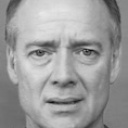

[[138 139 140 ... 136 136 136]
 [135 137 138 ... 135 135 136]
 [136 137 138 ... 135 136 136]
 ...
 [115 115 114 ... 123 123 124]
 [116 116 115 ... 123 123 123]
 [116 116 115 ... 123 123 122]]
(79, 128)


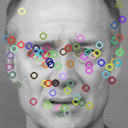

In [169]:
#SIFT features

sift = cv2.SIFT_create()
X_data = []
y_data = []

for file_path in set_of_classes:
    list_of_files = sorted(glob.glob('./CREMA-D/FaceClass/' + file_path + '/*.jpg'))
    count = 0
    for image_path in list_of_files:
        gray = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
        _,des = sift.detectAndCompute(gray,None)
        X_data.append(des)
        y_data.append(file_path)
        

print(X_data)
display(Image.fromarray(arr_img))

print(arr_img)

display(Image.fromarray(gray))
print(gray)


sift = cv2.SIFT_create()
kp,des = sift.detectAndCompute(gray,None)


#kp,des = sift.compute(gray,kp)
print(np.shape(des))
#img=cv2.drawKeypoints(gray,kp,image)
display(Image.fromarray(img))

#cv2.imwrite(str(w) + str(h) + '_faces.jpg', gray)

In [ ]:
#LBP features
def LBP(img):
    arr = np.zeros((len(gray),len(gray[0])))
    img = cv2.copyMakeBorder(img, 1, 1, 1, 1, cv2.BORDER_REFLECT)
    img = np.array(img)
    for i in range(len(img)-2):
        for j in range(len(img[i])-2):
            arr[i][j] = (img[i + 1][j + 1] < img[i][j]) * 1 + \
                        (img[i + 1][j + 1] < img[i][j+1]) * 2 + \
                        (img[i + 1][j + 1] < img[i][j+2]) * 4 + \
                        (img[i + 1][j + 1] < img[i+1][j+2]) * 8 + \
                        (img[i + 1][j + 1] < img[i+2][j+2]) * 16 + \
                        (img[i + 1][j + 1] < img[i+2][j+1]) * 32 + \
                        (img[i + 1][j + 1] < img[i+2][j]) * 64 + \
                        (img[i + 1][j + 1] < img[i+1][j]) * 128
    return np.uint8(arr)


#arr = np.zeros((len(gray),len(gray[0])))
#print(np.shape(arr))
#image2 = cv2.copyMakeBorder(gray, 1, 1, 1, 1, cv2.BORDER_REFLECT)
#display(Image.fromarray(image2))
X_data = []
y_data = []
for file_path in set_of_classes:
    list_of_files = sorted(glob.glob('./CREMA-D/FaceClass/' + file_path + '/*.jpg'))
    count = 0
    for image_path in list_of_files:
        gray = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
        arr_img = LBP(gray)
        X_data.append(arr_img)
        y_data.append(file_path)
        

print(X_data)
display(Image.fromarray(arr_img))

print(arr_img)




In [ ]:
#For Next Train
#arr_img2 = np.float64(arr)
#arr_img2 = (arr_img - np.min(arr_img)) / (np.max(arr_img) - np.min(arr_img))

------------------------------- Аудио сектор ----------------------------------

In [14]:
def mel(spec):
    spec = 1125 * np.log(1 + spec/700)
    return spec

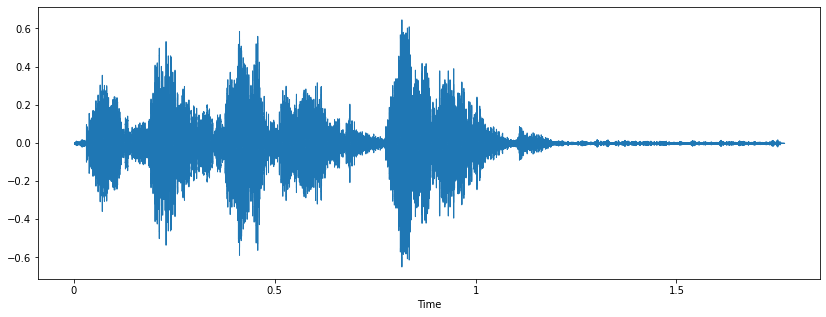

In [72]:
#AudioWaveForms
#Just analyze audio
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Draw audio signal in time dimension 
    plt.figure(figsize=figsize)
    librosa.display.waveshow(wav, sr=sr)
    plt.show()


wav_hi, sr_hi = librosa.load("CREMA-D/AudioClass/HAP/1001_IEO_HAP_HI.wav")
wav_lo, sr_lo = librosa.load("CREMA-D/AudioClass/SAD/1001_IEO_SAD_HI.wav")
draw_waveform(wav_hi, sr_hi)
ipd.Audio(wav_hi, rate=sr_hi)
#draw_waveform(wav_lo, sr_lo)
#ipd.Audio(wav_lo, rate=sr_lo)

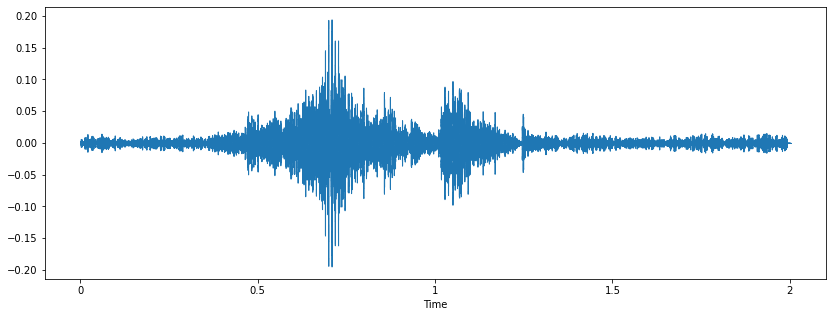

In [57]:
draw_waveform(wav_lo, sr_lo)
ipd.Audio(wav_lo, rate=sr_lo)

(5, 77)


[Text(0.5, 1.0, 'MFCC')]

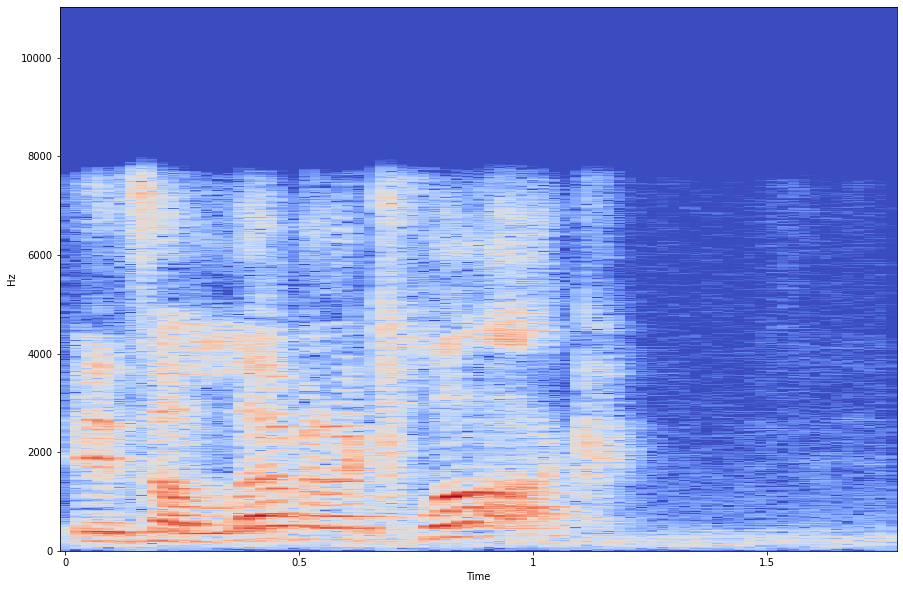

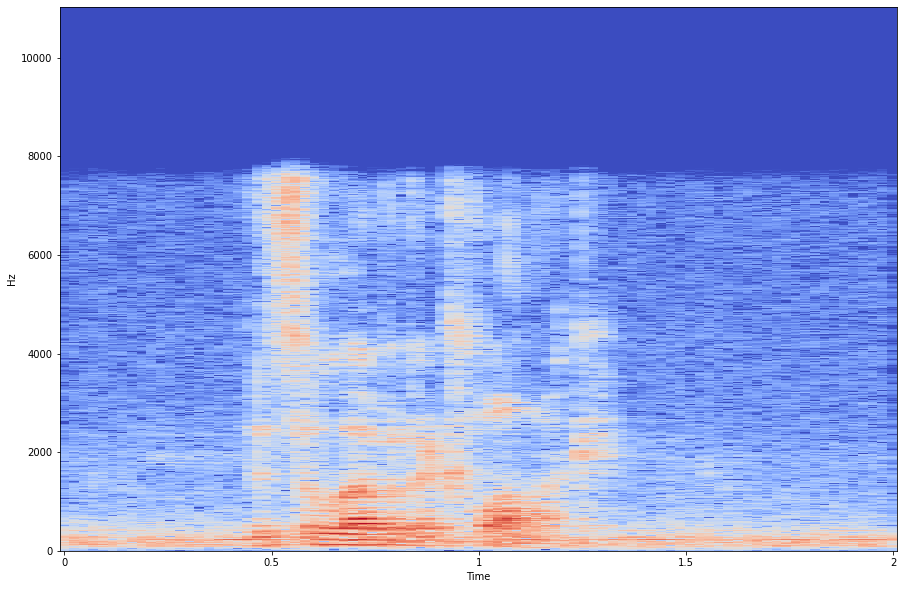

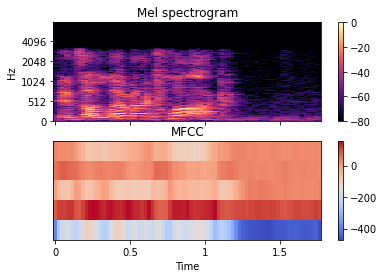

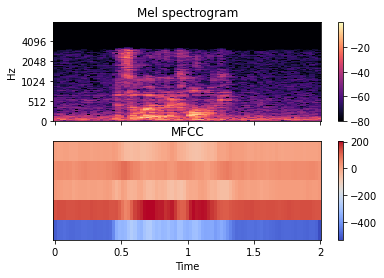

In [73]:


#high speech
stft_hi = librosa.stft(wav_hi)
stft_db = librosa.amplitude_to_db(mel(abs(stft_hi)))
plt.figure(figsize=(15,10))
librosa.display.specshow(stft_db, sr=sr_hi, x_axis='time', y_axis='hz')

#low speech
stft_lo = librosa.stft(wav_lo)
stft_db = librosa.amplitude_to_db(mel(abs(stft_lo)))
plt.figure(figsize=(15,10))
librosa.display.specshow(stft_db, sr=sr_lo, x_axis='time', y_axis='hz')


mfccs_hi = librosa.feature.mfcc(y = wav_hi, sr = sr_hi, n_mfcc=5)
mfccs_lo = librosa.feature.mfcc(y = wav_lo, sr = sr_lo, n_mfcc=5)


import matplotlib.pyplot as plt
#High
fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.amplitude_to_db(mel(abs(stft_hi)), ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogram')
ax[0].label_outer()
img = librosa.display.specshow(mfccs_hi, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC')

#Low
fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.amplitude_to_db(mel(abs(stft_lo)), ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogram')
ax[0].label_outer()
img = librosa.display.specshow(mfccs_lo, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC')

In [ ]:
#MFFC Features
X_data =[]
y_data = []
for file_path in set_of_classes:
    list_of_files = sorted(glob.glob('./CREMA-D/AudioClass/' + file_path + '/*.wav'))
    for audio_file in list_of_files:
        wav, sr = librosa.load(audio_file)
        mfccs = librosa.feature.mfcc(y = wav, sr = sr)
        X_data.append(mfccs)
        y_data.append(file_path)
    


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, y_data,test_size=0.2, random_state=1)

In [143]:
#OpenSmile Features

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)
set_of_name_of_features = smile.feature_names


X_data_smile = []
y_data_smile = []

for file_path in set_of_classes:
    list_of_files = sorted(glob.glob('./CREMA-D/AudioClass/' + file_path + '/*.wav'))
    for audio_file in list_of_files:
        wav, sr = librosa.load(audio_file)
        res = smile.process_signal(
            wav,
            sr
        )
        X_data_smile_part = []
        for name in set_of_name_of_features:
            X_data_smile_part.append(res[name].values[0])
        X_data_smile.append(X_data_smile_part)
        y_data_smile.append(file_path)
        



In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data_smile, y_data_smile,test_size=0.2, random_state=1)